Trying to recreate 20200112_2.h5ad using the HTML Derek sent me.

In [1]:
#import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import scanpy as sc
import scipy

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [3]:
prefix = "/data/xyzeq/"

In [4]:
data = dict()

In [5]:
data['adata'] = sc.read_10x_h5(prefix + '10x/5prime_liver/outs/raw_feature_bc_matrix.h5').copy()

reading /data/xyzeq/10x/5prime_liver/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
data['adata'].var_names_make_unique()

In [7]:
##post processing filter minimum UMIS and genes
sc.pp.filter_cells(data['adata'], min_counts=500)#300
sc.pp.filter_cells(data['adata'], min_genes=100)

##post processing filter genes 
#sc.pp.filter_genes(adata, max_cells=1000)   

## define mito genes 
mito_genes=[name for name in data['adata'].var_names if name.startswith(('mm10___mt-', 'GRCh38_MT-'))]

filtered out 732196 cells that haveless than 500 counts
filtered out 273 cells that haveless than 100 genes expressed


In [8]:
##create new obs anotation to define percent mito for each cell 
data['adata'].obs['percent_mito'] = np.sum(data['adata'][:, mito_genes].X, axis=1) / np.sum(data['adata'].X, axis=1)*100

##create new obs anotation to define UMIs per cell
data['adata'].obs['n_counts'] = data['adata'].X.sum(axis=1)

In [9]:
##filter out outliers
data['adata'] = data['adata'][data['adata'].obs['n_genes'] < 10000, :].copy()

data['adata'] = data['adata'][data['adata'].obs['n_counts'] < 75000, :].copy()

data['adata'] = data['adata'][data['adata'].obs['percent_mito'] < 7.5, :].copy()

In [10]:
data['adata'].shape

(4027, 64591)

In [11]:
mouse_genes=[name for name in data['adata'].var_names if name.startswith('mm10__')]
human_genes=[name for name in data['adata'].var_names if name.startswith('GRCh38_')]
data['adata'].obs['mouse_counts'] = np.sum(data['adata'][:, mouse_genes].X, axis=1)
data['adata'].obs['human_counts'] = np.sum(data['adata'][:, human_genes].X, axis=1)

In [12]:
np.seterr(divide = 'ignore') 
data['adata'].obs['ratio'] = np.log10(np.true_divide(data['adata'].obs['mouse_counts'], data['adata'].obs['human_counts']))

def cell_call(counts):
        if counts['ratio'] > 0.66:
                return 'M'
        elif counts['ratio'] < -0.66:
                return 'H'
        else:
                return 'C'

data['adata'].obs['cell_call']=data['adata'].obs.apply(lambda counts: cell_call(counts), axis=1)

In [13]:
# I skip this, the raw attribute in Scanpy really sucks
data['adata_raw'] = sc.pp.log1p(data['adata'], copy=True)

In [14]:
##normalize counts per cell to 10K each 
sc.pp.normalize_per_cell(data['adata'], counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    Gene indices [42613, 61907, 63926] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:03)


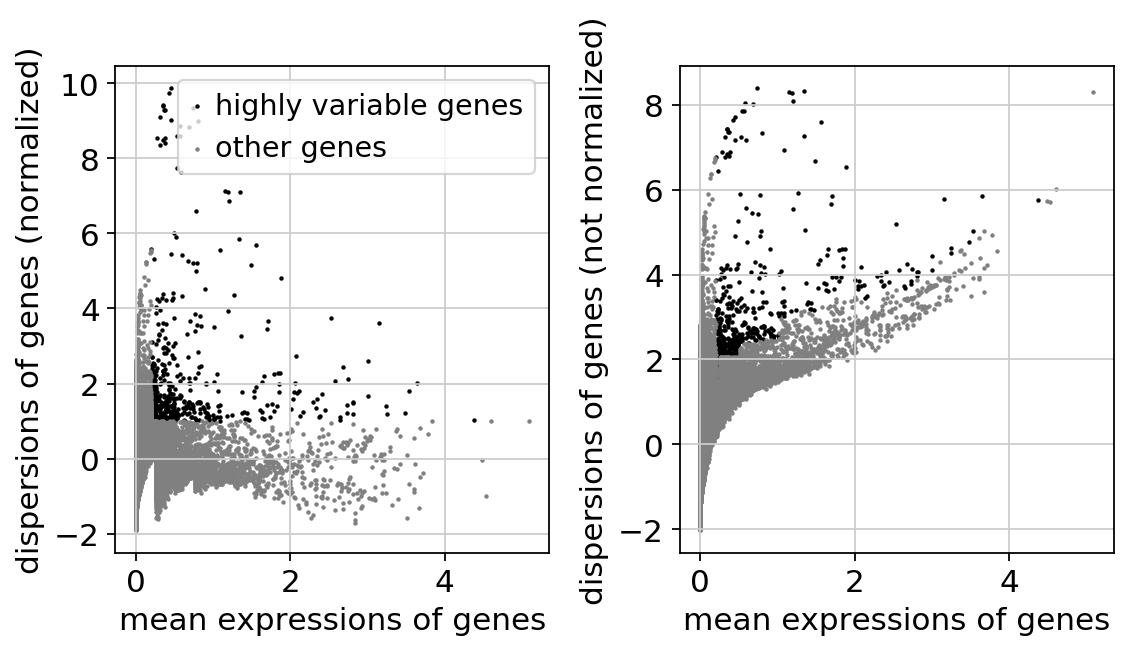

In [15]:
filter_result = sc.pp.filter_genes_dispersion(
    data['adata'].X,
    min_mean=0.20, 
    max_mean=7,
    min_disp=1) 
sc.pl.filter_genes_dispersion(filter_result)

In [16]:
data['adata']=data['adata'][:,filter_result.gene_subset].copy()

In [17]:
sc.pp.log1p(data['adata'])

In [18]:
sc.pp.regress_out(data['adata'], ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


... storing 'cell_call' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


    finished (0:00:04)


In [20]:
sc.pp.scale(data['adata'], max_value=10)

    ... clipping at max_value 10


In [21]:
sc.tl.pca(data['adata'], svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


In [22]:
sc.pp.neighbors(data['adata'], n_neighbors=25, n_pcs=25)

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 25
    computed neighbors (0:00:00)
    computed connectivities (0:00:04)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)


In [24]:
sc.tl.leiden(data['adata'], resolution=0.5)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [25]:
sc.tl.umap(data['adata'])

computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


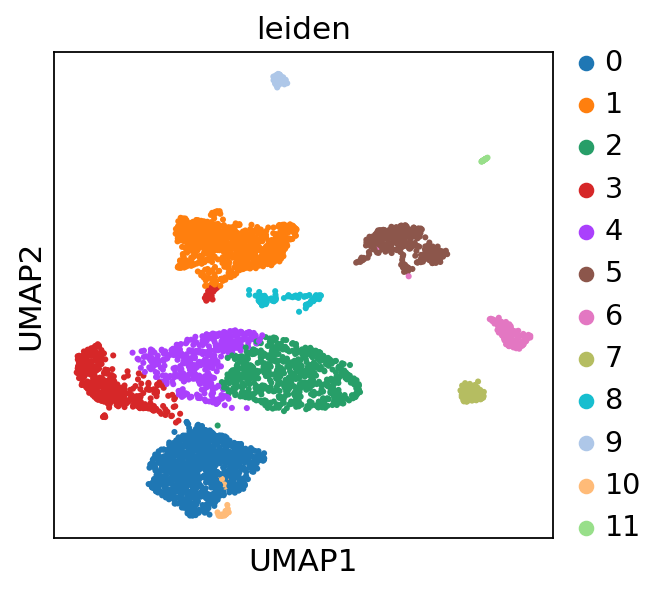

In [26]:
sc.pl.umap(data['adata'],color='leiden')

Okay, again looks extremely similar but not identical to Derek's UMAP. I've run it a few times and (I don't think) it's due to random seed. Should figure out what the discrepancies are. Lymphocytes look slightly different.

In [28]:
data['adata'].write_h5ad(prefix + '/10x/5prime_liver/20200112/20200112_2.recreated.h5ad')
# adata = sc.read_h5ad(prefix + '/10x/5prime_liver/20200112/20200112_2.recreated.h5ad')